In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from IPython.display import clear_output

import math
import random as ran
from scipy.stats import truncnorm
import pandas as pd
import seaborn as sbn
import time


In [2]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])



def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


class PlotLosses:
    def __init__(self):
        self.i = 0
        self.x = []
        self.losses = []
        
        self.fig = plt.figure()
        
        self.bins = np.linspace(0, 1, num=20)

    def update_plots(self, it, loss, sample_D_values=[], best_obj=0, elapsed_time=0):
        
        self.x.append(self.i)
        self.losses.append(loss)
        self.i += it

        clear_output(wait=True)

        f, (ax1, ax2) = plt.subplots(1, 2, sharex=False)
        f.set_size_inches(12,4)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.set_title('Generator loss')
        ax1.annotate(f'Current loss={loss:.4f}', xy=(0.5,0.5), xycoords='axes fraction')
        ax1.annotate(f'Best Obj={best_obj:.4f}', xy=(0.5,0.6), xycoords='axes fraction')
        ax1.annotate(f'Elap. time={elapsed_time:.2f} sec.', xy=(0.5,0.7), xycoords='axes fraction')
        ax1.legend()
        
        try:
            sbn.kdeplot(sample_D_values, ax=ax2, shade=True)
    #         ax2.hist(sample_D_values, bins=self.bins, label="P(sample is feasible)")
            ax2.set_title('Sample Discriminator Outputs (KDE)')
            ax2.set_xlim(0, 1.1)
            
        except:
            pass


        plt.show();
     
        


class Generator:
    
    def __init__(self, in_dim=10, hd_dim=50, out_dim=100):
        self.in_dim = in_dim
        self.hd_dim = hd_dim
        self.out_dim = out_dim
        
        self.Z = tf.placeholder(tf.float32, shape=[None, in_dim])

        self.G_W1 = tf.Variable(xavier_init([in_dim, hd_dim]))
        self.G_b1 = tf.Variable(tf.zeros(shape=[hd_dim]))

        self.G_W2 = tf.Variable(xavier_init([hd_dim, out_dim]))
        self.G_b2 = tf.Variable(tf.zeros(shape=[out_dim]))

        self.theta_G = [self.G_W1, self.G_W2, self.G_b1, self.G_b2]
    
        G_h1 = tf.nn.relu(tf.matmul(self.Z, self.G_W1) + self.G_b1)
        G_log_prob = tf.matmul(G_h1, self.G_W2) + self.G_b2
        self.X = tf.nn.sigmoid(G_log_prob)
        
        

    
class Discriminator:
    def __init__(self, x, train=False):
        self.tot_infs = 0.0
        self.tot_infs_nor = 0.0
        self.x = x
        self.train = train
        self.x_threshold = 0.001
        self.Zstar = tf.placeholder(tf.float32, name='Zstar')
        self.inf_scale = tf.placeholder(tf.float32, name='inf_scale')
    
    # ax <= b
    def add_linear_con(self, a, b):
        l = tf.einsum('n,mn->m', tf.convert_to_tensor(a, dtype=tf.float32), self.x)
        infs = tf.nn.relu(l - b)
        self.tot_infs += infs
        
    # lb <= card(x) <= b
    def add_card_constraint(self, lb, ub):
        if self.train:
            num_non_zeros = tf.reduce_sum(tf.nn.tanh(self.x / self.x_threshold), axis=1)
            self.tot_infs += tf.nn.relu(tf.subtract(num_non_zeros, ub)) + tf.nn.relu(tf.subtract(lb, num_non_zeros))
        else:
            num_non_zeros = tf.count_nonzero(tf.nn.relu(self.x-self.x_threshold), axis=1, dtype=tf.float32)
            self.tot_infs += tf.nn.relu(tf.subtract(num_non_zeros, ub)) + tf.nn.relu(tf.subtract(lb, num_non_zeros))
    
    # xQx + ax <= b
    def add_quadratic_con(self, Q, a, b):
        xQ = tf.einsum('ki,ij->kj', self.x, tf.convert_to_tensor(Q, dtype=tf.float32))
        xQx = tf.einsum('ki,ki->k', xQ, self.x)

        l = tf.einsum('n,mn->m', tf.convert_to_tensor(a, dtype=tf.float32), self.x)
        infs = tf.nn.relu(xQx + l - b)
        self.tot_infs += infs
    
    # sum |x-a| >= b
    def add_abs_con(self, a, b):
        l = tf.reduce_sum(tf.abs(self.x - a), axis=1)
        infs = tf.nn.relu(b - l)
        self.tot_infs += infs
        
    # min xQx + ax (<= Zstar)
    def set_objective(self, Q, a):
        xQ = tf.einsum('ki,ij->kj', self.x, tf.convert_to_tensor(Q, dtype=tf.float32))
        xQx = tf.einsum('ki,ki->k', xQ, self.x)

        l = tf.einsum('n,mn->m', tf.convert_to_tensor(a, dtype=tf.float32), self.x)
        self.objs = xQx + l
        infs = tf.nn.relu(xQx + l - self.Zstar)
        self.tot_infs += infs
        
    def finalize_inf(self):
#         self.fea_probs = 1.0/ tf.maximum(self.tot_infs, 0.001)
#         self.fea_probs = tf.nn.relu(1. - tf.minimum(self.tot_infs/100.0, 0.99))
        self.fea_probs = tf.nn.relu(1. - tf.nn.tanh(self.tot_infs/self.inf_scale))
#         self.fea_probs = 1 - tf.divide(self.tot_infs, tf.reduce_max(self.tot_infs) + 0.001)

            
    def get_objective(self):
        return self.objs



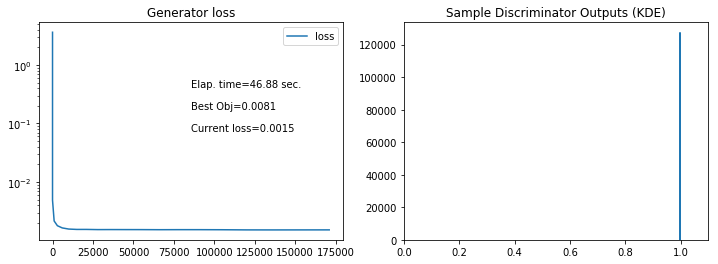

In [3]:



X_dim = 100
HL_dim = 50
Z_dim = 10



loss_plot = PlotLosses()


np.random.seed(0)
Omega = np.random.rand(X_dim, X_dim)/20.0

LHSs = [
    np.ones(X_dim),
    -np.ones(X_dim),
    [1 if i < 30 else 0 for i in range(X_dim)],
    [-1 if i < 30 else 0 for i in range(X_dim)],
]

RHSs = [
    1,
    -1,
    0.3,
    -0.2
]

card_upper = 12.0
card_lower = 7.0


G = Generator(Z_dim, HL_dim, X_dim)

sample_X = tf.placeholder(tf.float32, shape=[None, X_dim])

sample_D = Discriminator(sample_X, train=False)
sample_D.add_linear_con(LHSs[0], RHSs[0])
sample_D.add_linear_con(LHSs[1], RHSs[1])
sample_D.add_linear_con(LHSs[2], RHSs[2])
sample_D.add_linear_con(LHSs[3], RHSs[3])
sample_D.add_card_constraint(card_lower, card_upper)
sample_D.add_quadratic_con(Omega, np.zeros(X_dim), 1)
sample_D.add_quadratic_con(-Omega, -np.zeros(X_dim), -0.25)
sample_D.add_abs_con(np.ones(X_dim)*0.1, 0.5)
sample_D.set_objective(Omega, -np.ones(X_dim)*0.01)
sample_D.finalize_inf()

train_D = Discriminator(G.X, train=True)
train_D.add_linear_con(LHSs[0], RHSs[0])
train_D.add_linear_con(LHSs[1], RHSs[1])
train_D.add_linear_con(LHSs[2], RHSs[2])
train_D.add_linear_con(LHSs[3], RHSs[3])
train_D.add_card_constraint(card_lower, card_upper)
train_D.add_quadratic_con(Omega, np.ones(X_dim)*0.1, 1)
train_D.add_quadratic_con(-Omega, -np.ones(X_dim)*0.1, -0.25)
train_D.add_abs_con(np.ones(X_dim)*0.1, 0.5)
train_D.set_objective(Omega, np.ones(X_dim)*0.01)
train_D.finalize_inf()

G_loss = -tf.reduce_mean(tf.log(train_D.fea_probs))
# G_loss = -tf.reduce_mean(train_D.fea_probs)

G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=G.theta_G)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

mb_size = 128

best_obj = 100000.0
best_sols = []

losses = []

start_time = time.time()

feasible_threshold = 0.995

adaptive_inf_scale = 100.0

for it in range(20000):
    if it % 1000 == 0:
        sample_noise = sample_Z(128, Z_dim)
        samples = sess.run(G.X, feed_dict={
            G.Z: sample_noise
        })
        sample_D_values, sample_obj_values = sess.run([
            sample_D.fea_probs,
            sample_D.objs
        ], feed_dict={
            sample_D.x: samples,
            sample_D.Zstar: best_obj,
            sample_D.inf_scale: adaptive_inf_scale
        })
        
        fea_sample_obj_values = sample_obj_values[sample_D_values > feasible_threshold]
        sols = samples[sample_D_values > feasible_threshold]
        if len(fea_sample_obj_values > 0):
            best_idx = np.argmin(fea_sample_obj_values)
            if np.min(fea_sample_obj_values) < best_obj:
                best_obj = np.minimum(fea_sample_obj_values[best_idx], best_obj)
                best_sols.append(sols[best_idx])
    
    _, G_loss_curr = sess.run([
        G_solver, 
        G_loss
    ], feed_dict={
        G.Z: sample_Z(mb_size, Z_dim),
        train_D.Zstar: best_obj,
        train_D.inf_scale: adaptive_inf_scale
    })

    if it % 1000 == 0:
        
        loss_plot.update_plots(
            it=it, 
            loss=G_loss_curr, 
            sample_D_values=sample_D_values,
            best_obj=best_obj,
            elapsed_time=time.time()-start_time
        )
        
        losses.append(G_loss_curr)
        
#         if len(losses) > 3:
#             if np.abs(np.max(losses[-3]) - np.min(losses[-3])) < 0.0001:
#                 adaptive_inf_scale = 10.0
#                 adaptive_inf_scale = np.maximum(adaptive_inf_scale, 1)
        


In [4]:
best_sols

[array([  2.36062215e-06,   3.28515694e-06,   6.70120644e-05,
          5.14284466e-07,   6.77902563e-06,   3.20304543e-01,
          6.17980959e-06,   3.48804642e-05,   1.30386718e-06,
          1.50492508e-03,   1.25050622e-06,   5.26852517e-08,
          1.88981369e-06,   1.08117329e-05,   2.07124415e-07,
          2.79255369e-06,   2.71119807e-05,   7.55756337e-05,
          6.28244152e-07,   1.14674549e-05,   1.18144080e-05,
          1.16180745e-05,   6.23167080e-06,   3.15080456e-06,
          8.64630329e-06,   8.86366706e-06,   2.19204776e-05,
          9.75202283e-07,   3.05952040e-06,   1.29763123e-06,
          3.22277469e-06,   1.87570439e-08,   1.84379332e-05,
          2.34595154e-06,   1.13913067e-07,   2.19798903e-06,
          5.13406810e-08,   1.46245220e-05,   4.13408316e-07,
          6.90697413e-03,   1.37282899e-02,   5.51447010e-06,
          5.02067905e-07,   6.33399850e-07,   1.19839287e-05,
          1.03140541e-03,   3.81075949e-07,   1.70502858e-07,
        